# Proyecto final: Modelización

Debemos construir un modelo de clasificación que prediga la probabilidad de que un paciente haya sufrido algún tipo de enfermedad cardíaca. Se ha de tener en cuenta que decirle a un asegurado que tiene una enfermedad cardíaca cuando realmente no la ha tenido supone un riesgo de pérdida de clientes y, en consecuencia, de ingresos mucho mayor que el hecho de no asignarle una enfermedad cardíaca a alguien que si la ha tenido. La aseguradora considera crucial que esta característica se vea reflejada en el modelo construido.

In [24]:
# Librerías

import pandas as pd
import numpy as np
from matplotlib import pyplot

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from itertools import compress

import xgboost as xgb
from bayes_opt import BayesianOptimization

## 1. Lectura de los datos

In [2]:
df = pd.read_csv("../Datos/heart_2020_cleaned.csv")

In [3]:
df.head(10)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
5,Yes,28.87,Yes,No,No,6.0,0.0,Yes,Female,75-79,Black,No,No,Fair,12.0,No,No,No
6,No,21.63,No,No,No,15.0,0.0,No,Female,70-74,White,No,Yes,Fair,4.0,Yes,No,Yes
7,No,31.64,Yes,No,No,5.0,0.0,Yes,Female,80 or older,White,Yes,No,Good,9.0,Yes,No,No
8,No,26.45,No,No,No,0.0,0.0,No,Female,80 or older,White,"No, borderline diabetes",No,Fair,5.0,No,Yes,No
9,No,40.69,No,No,No,0.0,0.0,Yes,Male,65-69,White,No,Yes,Good,10.0,No,No,No


## 2. Codificación de variables categóricas

In [4]:
# Antes de nada, un vistazo general a las categorías de cada una de las vars. no numéricas

categorical = df.select_dtypes(include=object)
categorical.head(5)

,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
0,No,Yes,No,No,No,Female,55-59,White,Yes,Yes,Very good,Yes,No,Yes
1,No,No,No,Yes,No,Female,80 or older,White,No,Yes,Very good,No,No,No
2,No,Yes,No,No,No,Male,65-69,White,Yes,Yes,Fair,Yes,No,No
3,No,No,No,No,No,Female,75-79,White,No,No,Good,No,No,Yes
4,No,No,No,No,Yes,Female,40-44,White,No,Yes,Very good,No,No,No


In [9]:
for col in categorical.columns:
    print("\n" + '\033[1m'+ str(col) + '\033[0m')
    print(pd.value_counts(categorical[col]))


HeartDisease
No     292422
Yes     27373
Name: HeartDisease, dtype: int64

Smoking
No     187887
Yes    131908
Name: Smoking, dtype: int64

AlcoholDrinking
No     298018
Yes     21777
Name: AlcoholDrinking, dtype: int64

Stroke
No     307726
Yes     12069
Name: Stroke, dtype: int64

DiffWalking
No     275385
Yes     44410
Name: DiffWalking, dtype: int64

Sex
Female    167805
Male      151990
Name: Sex, dtype: int64

AgeCategory
65-69          34151
60-64          33686
70-74          31065
55-59          29757
50-54          25382
80 or older    24153
45-49          21791
75-79          21482
18-24          21064
40-44          21006
35-39          20550
30-34          18753
25-29          16955
Name: AgeCategory, dtype: int64

Race
White                             245212
Hispanic                           27446
Black                              22939
Other                              10928
Asian                               8068
American Indian/Alaskan Native      5202
Name: Race

### 2.1 Label encodig for ordinal variables

Given what we have seen above, we can distinguish the following two **ordinal** variables: **GenHealth** and **AgeCategory**. We won't consider Diabetic as ordinal because the category "*Yes (during pregnancy)*" cannot be ordered in an obvious way within a scale of diabetes intenisty.

In [10]:
# Import label encoder
from sklearn.preprocessing import LabelEncoder
  
# Applying  encoding to ordinal categorical variables
label_encoder = LabelEncoder()
df_encoded = df.copy()
df_encoded['GenHealth']= label_encoder.fit_transform(df['GenHealth'])
df_encoded['AgeCategory']= label_encoder.fit_transform(df['AgeCategory'])

df_encoded[['GenHealth', 'AgeCategory']].head(10)

,GenHealth,AgeCategory
0,4,7
1,4,12
2,1,9
3,2,11
4,4,4
5,1,11
6,1,10
7,2,12
8,1,12
9,2,9


### 2.2 One Hot encoding for non-ordinal variables

In [11]:
df_encoded = pd.get_dummies(df_encoded, drop_first=True)
df_encoded.head(5)

,BMI,PhysicalHealth,MentalHealth,AgeCategory,GenHealth,SleepTime,HeartDisease_Yes,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,...,Race_Hispanic,Race_Other,Race_White,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_Yes,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
0,16.60,3.0,30.0,7,4,5.0,0,1,0,0,...,0,0,1,0,1,0,1,1,0,1
1,20.34,0.0,0.0,12,4,7.0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
2,26.58,20.0,30.0,9,1,8.0,0,1,0,0,...,0,0,1,0,1,0,1,1,0,0
3,24.21,0.0,0.0,11,2,6.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,23.71,28.0,0.0,4,4,8.0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


## 3. Train-test separation

Antes de aplicar técnicas de selección de variables y cualquier otro pre-procesamiento restante, partiremos los datos en los subconjuntos de train y test. Los criterios y algoritmos de selección de variables se aplicarán sobre train para identificar los atributos a eliminar, y posteriormente se eliminarán esos mismos atributos del subconjunto de test.

In [12]:
# Train-test separation
X = df_encoded.drop(['HeartDisease_Yes'], axis=1)
y = df_encoded[['HeartDisease_Yes']]

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size = 0.3, random_state = 123)

print("\n" + '\033[1m'+ 'Distribución del target en train' + '\033[0m')
print(pd.value_counts(y_train['HeartDisease_Yes']))

print("\n" + '\033[1m'+ 'Distribución del target en test' + '\033[0m')
print(pd.value_counts(y_test['HeartDisease_Yes']))


Distribución del target en train
0    204876
1     18980
Name: HeartDisease_Yes, dtype: int64

Distribución del target en test
0    87546
1     8393
Name: HeartDisease_Yes, dtype: int64


Se mantienen porcentajes similares de target=1 en train (9.26%) y test (9.58%), por lo que no vemos necesario aplicar sampling estratificado

In [20]:
# La estandarización de variables previa al entrenamiento nos interesa para evaluar 
# posteriormente la importancia de cada variable

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 4. Selección de variables

Existen múltiples técnicas y criterios que pueden aplicarse. Nosotros nos hemos decantado por los que se muestran a continuación.

### 4.1 Eliminación de variables altamente correladas

In [21]:
df.corr()

,BMI,PhysicalHealth,MentalHealth,SleepTime
BMI,1.000000,0.109788,0.064131,-0.051822
PhysicalHealth,0.109788,1.000000,0.287987,-0.061387
MentalHealth,0.064131,0.287987,1.000000,-0.119717
SleepTime,-0.051822,-0.061387,-0.119717,1.000000


Ningun atributo presenta un coeficiente de correlación de Pearson alto; de hecho la correlación lineal entre las variables numéricas de nuestro conjunto de datos es notablemente bajo. No hay por tanto información redundante que entorpezca el entrenamiento provocando el sobreajuste del modelo al ruido.

## 5. Enriquecimiento del dataset: clustering

## 6. Modelización

In [22]:
# Conjunto de validación para búsqueda Bayesiana
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train_scaled, 
                                                                    y_train, 
                                                                    test_size = 0.2, 
                                                                    random_state = 123)

In [29]:
# Busqueda Bayesiana de hiperparámetros

# Defining the search space
space = {"eta": (0, 1),
         "gamma":(0, 10), 
         "max_depth":(3, 12),
         "min_child_weight": (0, 5)}

# Defining the objective function
def objective(eta, gamma, max_depth, min_child_weight):
    
    """
    Objective function to minimize for the Bayesian optimizer
        
    Parameters
    ==========
    eta, gamma, max_depth, min_child_weight
        
    Return
    ======
        
    loss : Cost value to minimize (in this case, binary_crossentropy)
    
        """
        
    max_depth = round(max_depth)
    min_child_weight = round(min_child_weight)
        
    # Creating the model
    model = xgb.XGBClassifier(use_label_encoder=False, 
                              random_state=1, 
                              learning_rate=0.02, 
                              n_estimators=500,
                              eta=eta,
                              gamma=gamma,
                              max_depth=max_depth,
                              min_child_weight=min_child_weight)
        
    # Fit the model
    model.fit(X_train_val, y_train_val)
        
    # Evaluating the model
    y_test_val_pred = model.predict(X_test_val)

    #accuracy = accuracy_score(y_test_val, y_test_val_pred)
    f1 = f1_score(y_test_val, y_test_val_pred)
        
    return f1

# Create the optimizer
optimizer = BayesianOptimization(
    f=objective,
    pbounds=space,
    random_state=1,
)
    
# Running the optimizer...
optimizer.maximize(
    init_points=2,
    n_iter=20,
)
    
# Optimal parameter values
params = optimizer.max['params']

|   iter    |  target   |    eta    |   gamma   | max_depth | min_ch... |
-------------------------------------------------------------------------
|  1        |  0.1265   |  0.417    |  7.203    |  3.001    |  1.512    |
|  2        |  0.1454   |  0.1468   |  0.9234   |  4.676    |  1.728    |
|  3        |  0.1458   |  0.1112   |  0.7758   |  4.78     |  1.895    |
|  4        |  0.1655   |  0.0      |  0.0      |  11.26    |  0.5579   |
|  5        |  0.1687   |  1.0      |  0.0      |  12.0     |  5.0      |
|  6        |  0.1563   |  1.0      |  6.341    |  12.0     |  5.0      |
|  7        |  0.1688   |  1.0      |  3.316    |  12.0     |  0.0      |
|  8        |  0.1392   |  0.0      |  10.0     |  12.0     |  0.0      |
|  9        |  0.1658   |  0.0      |  2.272    |  12.0     |  3.025    |
|  10       |  0.1672   |  1.0      |  0.0      |  12.0     |  0.0      |
|  11       |  0.1649   |  1.0      |  0.0      |  12.0     |  2.683    |
|  12       |  0.1614   |  1.0      | 

In [31]:
# Creating the model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, 
                              random_state=1, 
                              learning_rate=0.02, 
                              n_estimators=500,
                              eta=params['eta'],
                              gamma=params['gamma'],
                              max_depth=round(params['max_depth']),
                              min_child_weight=round(params['min_child_weight']))

# Fit the model
xgb_model.fit(X_train_scaled, y_train)
        
# Evaluating the model
y_test_pred = xgb_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_test_pred)

print(accuracy)

0.9129759534704344


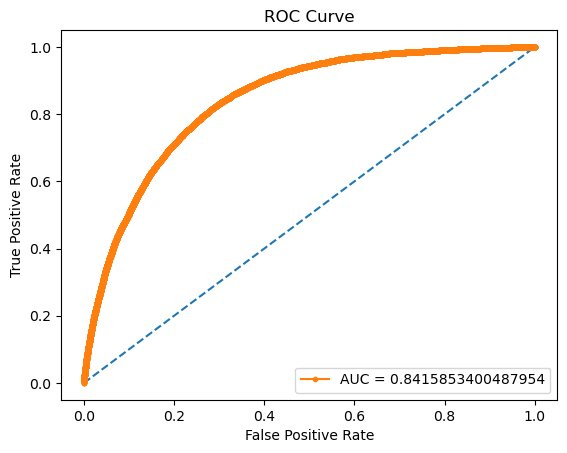

In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

false_pos_rate, true_pos_rate, proba = roc_curve(y_test, xgb_model.predict_proba(X_test_scaled)[:, -1])
pyplot.figure()
pyplot.plot([0,1], [0,1], linestyle="--") # plot random curve
pyplot.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:, -1])}")
pyplot.title("ROC Curve")
pyplot.ylabel("True Positive Rate")
pyplot.xlabel("False Positive Rate")
pyplot.legend(loc="lower right")

In [36]:
optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in xgb_model.predict_proba(X_test_scaled)[:, -1]]

In [38]:
print("Accuracy Score Before and After Thresholding: {}, {}".format(accuracy_score(y_test, y_test_pred), accuracy_score(y_test, roc_predictions)))
print("Precision Score Before and After Thresholding: {}, {}".format(precision_score(y_test, y_test_pred), precision_score(y_test, roc_predictions)))
print("Recall Score Before and After Thresholding: {}, {}".format(recall_score(y_test, y_test_pred), recall_score(y_test, roc_predictions)))
print("F1 Score Before and After Thresholding: {}, {}".format(f1_score(y_test, y_test_pred), f1_score(y_test, roc_predictions)))

Accuracy Score Before and After Thresholding: 0.9129759534704344, 0.7252837740647703
Precision Score Before and After Thresholding: 0.5149659863945578, 0.21623329436668667
Recall Score Before and After Thresholding: 0.0901942094602645, 0.8154414392946503
F1 Score Before and After Thresholding: 0.15350299097637635, 0.34182399360703225


In [39]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, roc_predictions)
confusion_matrix

array([[62739, 24807],
       [ 1549,  6844]])